# What Happens with Many Speakers?

So far, we've tested with 2-3 speakers. But what happens when we scale to **10, 15, or 20 speakers**? How do conversation dynamics change? Do metrics break down?

This post explores:
1. **Scaling conversations** to 10+ speakers
2. **Fixing conclusiveness calculation**: The persistent 0/0 -> 5 issue
3. **Analyzing group dynamics** using ConvoKit
4. **Visualizing speaker networks** to understand interactions


## Setup and Imports


In [1]:
import os
import re
from typing import List, Dict
from collections import defaultdict
from dotenv import load_dotenv
from openai import OpenAI
from tqdm import tqdm
from random import shuffle, choice, random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# ConvoKit imports
from convokit import Corpus, Utterance, Speaker
from convokit.text_processing import TextParser
from convokit import PolitenessStrategies
from convokit.coordination import Coordination

load_dotenv("../../.env")
client = OpenAI()


/home/ezou626/repos/comm4190_F25_Using_LLMs_Blog/.venv/lib/python3.11/site-packages/convokit/coordination/coordination.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Scalable Conversation Runner

We'll create a conversation runner that can handle many speakers efficiently.


In [2]:
def run_scaled_conversation(
    iterations: int,
    participant_count: int,
) -> List[Dict]:
    """Run a conversation with many participants."""
    conversation_history = []
    ordering = list(range(1, participant_count + 1))
    last_speaker = -1
    identity_summaries = {}
    
    # Bootstrap identities
    for pid in tqdm(ordering, desc="Bootstrapping identities"):
        speaker_id = f"speaker_{pid}"
        bootstrap_messages = [
            {
                "role": "system",
                "content": (
                    f"You are {speaker_id} in a group conversation."
                    "You do not know who the others are yet. "
                    "Imagine your own background, priorities, and communication "
                    "style. First, in 2-3 sentences, describe who you are and "
                    "what you care about. Then start the conversation by introducing "
                    "a topic you'd like to discuss, or respond to others if they've "
                    "already started talking."
                ),
            },
            {"role": "user", "content": "Welcome to the conversation! Feel free to introduce a topic or join in the discussion."},
        ]
        
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=bootstrap_messages,
            store=False,
        )
        first_message = response.choices[0].message.content
        identity_summaries[speaker_id] = first_message
        conversation_history.append(
            {"role": "assistant", "name": speaker_id, "content": first_message}
        )
    
    def build_message(history: List[Dict], speaker_id: str, window_size: int) -> List[Dict]:
        speaker_messages = [msg for msg in history if msg.get("name") == speaker_id][-window_size:]
        other_messages = [
            msg for msg in history
            if msg.get("name") not in (None, speaker_id)
        ][-window_size:]
        
        transcript = []
        persona_reminder = identity_summaries.get(speaker_id, "")
        if persona_reminder:
            transcript.append("Here is a brief reminder of how you have been speaking so far:")
            transcript.append(f"- {persona_reminder}")
        
        if speaker_messages:
            transcript.append("\\nRecent messages from you:")
            transcript.extend(f"- {msg['content']}" for msg in speaker_messages)
        
        if other_messages:
            transcript.append("\\nRecent messages from others:")
            transcript.extend(
                f"- {msg.get('name', msg['role'])}: {msg['content']}"
                for msg in other_messages
            )
        
        transcript_str = "\\n".join(transcript)
        
        return history + [
            {
                "role": "user",
                "content": (
                    f"{speaker_id}, continue the conversation and respond to the "
                    "others. Stay consistent with how you have been speaking so "
                    "far, and look for ways to add something new that has not "
                    "yet been covered."
                ),
            },
            {
                "role": "assistant",
                "name": speaker_id,
                "content": f"I should remember that the following is the most current state of the conversation.\\n{transcript_str}\\n\\n",
            },
        ]
    
    def shuffle_order(order: List[int]) -> List[int]:
        first = choice(order[:-1])
        remaining = [p for p in order if p != first]
        shuffle(remaining)
        return [first] + remaining
    
    for i in tqdm(range(iterations), desc=f"Running {participant_count}-speaker conversation"):
        if i > 0:
            ordering = shuffle_order(ordering)
        
        for pid in ordering:
            if random() < 0.3 or last_speaker == pid:
                continue
            
            speaker_id = f"speaker_{pid}"
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=build_message(conversation_history, speaker_id, 5),
                store=False,
            )
            message = response.choices[0].message.content
            conversation_history.append(
                {"role": "assistant", "name": speaker_id, "content": message}
            )
            last_speaker = pid
    
    return conversation_history


## Improved Conclusiveness Calculation

The issue is that simple keyword matching often finds 0 agreement and 0 disagreement markers, leading to 0/0 -> 5.0. We'll improve this by:
1. Expanding marker detection with strong/moderate patterns
2. Direct utterance processing (avoiding Coordination transformer to prevent StopIteration errors)
3. Adding debugging to see what's happening
4. Using weighted counts (strong markers count more than moderate ones)


In [11]:
def conversation_to_corpus(conversation_history: List[Dict]) -> Corpus:
    """Convert conversation history to a ConvoKit Corpus."""
    utterances = []
    
    for idx, msg in enumerate(conversation_history):
        if msg.get("role") == "assistant" and "name" in msg:
            speaker_id = msg["name"]
            text = msg["content"]
            
            utterance = Utterance(
                id=f"utt_{idx}",
                speaker=Speaker(id=speaker_id),
                text=text
            )
            utterance.meta["timestamp"] = idx
            utterances.append(utterance)
    
    return Corpus(utterances=utterances)

def compute_conclusiveness_score_improved(corpus: Corpus, debug: bool = False) -> float:
    """
    Improved conclusiveness score with better marker detection.
    
    The issue: Simple keyword matching often finds 0 markers, leading to 0/0 -> 5.0.
    Solution: Expanded markers + better detection (without Coordination transformer to avoid StopIteration).
    """
    if debug:
        print("[DEBUG] compute_conclusiveness_score_improved called")
    try:
        # Check if corpus is valid
        if corpus is None:
            if debug:
                print("[DEBUG] Corpus is None, returning 5.0")
            return 5.0
        
        if debug:
            print(f"[DEBUG] Corpus type: {type(corpus)}")
        
        # Get utterances directly without Coordination transformer (more reliable)
        try:
            utterances = list(corpus.iter_utterances())
            if debug:
                print(f"[DEBUG] Retrieved {len(utterances)} utterances")
        except (AttributeError, TypeError) as e:
            if debug:
                print(f"[DEBUG] Error getting utterances: {e}")
            return 5.0
        
        if len(utterances) == 0:
            if debug:
                print("[DEBUG] No utterances found, returning 5.0")
            return 5.0
        
        # Expanded agreement markers (using word boundaries to avoid false positives)
        # Strong agreement markers
        strong_agreement_patterns = [
            r'\bagree\b', r'\bagreed\b', r'\bagreeing\b', r'\bagreement\b',
            r'\bexactly\b', r'\babsolutely\b', r'\bdefinitely\b', r'\bcertainly\b',
            r'\bindeed\b', r'\bprecisely\b', r'\bcorrect\b', r'\bright\b',
            r'\btrue\b', r'\bthat\'?s right\b', r'\bthat\'?s correct\b',
            r'\bi agree\b', r'\bwe agree\b', r'\bi completely agree\b',
            r'\bexactly right\b', r'\bspot on\b', r'\bwell said\b',
            r'\bperfect\b', r'\bexcellent point\b', r'\bthat\'?s exactly\b',
            r'\babsolutely right\b', r'\bdefinitely right\b', r'\bcompletely agree\b',
            r'\bwholeheartedly\b', r'\bunquestionably\b', r'\bwithout doubt\b'
        ]
        
        # Moderate agreement markers
        moderate_agreement_patterns = [
            r'\byes\b', r'\byeah\b', r'\byep\b', r'\byup\b', r'\bsure\b', r'\bokay\b', r'\bok\b',
            r'\bthat makes sense\b', r'\bthat\'?s a good point\b', r'\bgood point\b',
            r'\bi see\b', r'\bi understand\b', r'\bi get it\b', r'\bi follow\b',
            r'\bthat\'?s fair\b', r'\bfair enough\b', r'\bthat\'?s reasonable\b',
            r'\bi think so\b', r'\bi believe so\b', r'\bprobably\b', r'\blikely\b',
            r'\bsimilar\b', r'\bsimilarly\b', r'\blikewise\b', r'\bsame here\b',
            r'\bme too\b', r'\bsame\b', r'\bconcur\b', r'\bconcurring\b',
            r'\bvalid\b', r'\bvalid point\b', r'\bsound\b', r'\bsound point\b',
            r'\bhelpful\b', r'\buseful\b', r'\binsightful\b', r'\binteresting\b',
            r'\bthat\'?s interesting\b', r'\bgood idea\b', r'\bgood thinking\b'
        ]
        
        # Strong disagreement markers
        strong_disagreement_patterns = [
            r'\bdisagree\b', r'\bdisagreed\b', r'\bdisagreeing\b', r'\bdisagreement\b',
            r'\bdispute\b', r'\bdisputing\b', r'\bdiffer\b', r'\bdiffered\b', r'\bdiffering\b',
            r'\bwrong\b', r'\bincorrect\b', r'\bnot correct\b', r'\bnot right\b',
            r'\bnot true\b', r'\bthat\'?s wrong\b', r'\bthat\'?s incorrect\b',
            r'\bi disagree\b', r'\bwe disagree\b', r'\bi strongly disagree\b',
            r'\bdon\'?t agree\b', r'\bdoesn\'?t agree\b', r'\bdidn\'?t agree\b',
            r'\bcan\'?t agree\b', r'\bcannot agree\b', r'\bwon\'?t agree\b',
            r'\bobject\b', r'\bobjection\b', r'\bchallenge\b', r'\bchallenging\b',
            r'\bcontradict\b', r'\bcontradicting\b', r'\bcontradiction\b',
            r'\bfalse\b', r'\buntrue\b', r'\bmistaken\b', r'\berror\b',
            r'\bflawed\b', r'\bproblematic\b', r'\bunacceptable\b', r'\bunreasonable\b',
            r'\babsurd\b', r'\bridiculous\b', r'\boutrageous\b', r'\bunfounded\b'
        ]
        
        # Moderate disagreement markers (more context-dependent)
        moderate_disagreement_patterns = [
            r'\bhowever\b', r'\balthough\b', r'\bbut\b', r'\bthough\b', r'\bwhereas\b',
            r'\bnot necessarily\b', r'\bnot quite\b', r'\bnot exactly\b', r'\bnot really\b',
            r'\bnot entirely\b', r'\bnot completely\b', r'\bnot fully\b',
            r'\bpartially\b', r'\bpartly\b', r'\bsomewhat\b', r'\bto some extent\b',
            r'\bcontrary\b', r'\bconversely\b', r'\bon the other hand\b',
            r'\bcontrast\b', r'\bcontrasting\b', r'\bunlike\b', r'\bdifferent\b',
            r'\bdifferently\b', r'\balternative\b', r'\balternatively\b',
            r'\bactually\b', r'\bin fact\b', r'\bin reality\b', r'\bthe reality is\b',
            r'\bwell\b', r'\bwait\b', r'\bhold on\b', r'\bnot so fast\b',
            r'\bnot sure\b', r'\bnot certain\b', r'\buncertain\b', r'\bdoubtful\b',
            r'\bquestionable\b', r'\bdebatable\b', r'\barguable\b', r'\bmaybe not\b',
            r'\bperhaps not\b', r'\bpossibly not\b', r'\bnot convinced\b',
            r'\bskeptical\b', r'\bskepticism\b', r'\bconcern\b', r'\bconcerned\b',
            r'\bissue\b', r'\bproblem\b', r'\bproblems\b', r'\bconcern\b',
            r'\bworry\b', r'\bworried\b', r'\bhesitant\b', r'\bhesitation\b',
            r'\bdispute\b', r'\bquestion\b', r'\bquestions\b', r'\bchallenge\b',
            r'\bdisagree with\b', r'\bdiffer from\b', r'\bcontrary to\b',
            r'\bin contrast\b', r'\bby contrast\b', r'\bunlike\b', r'\bversus\b',
            r'\bvs\b', r'\bcompared to\b', r'\bcompared with\b'
        ]
        
        # Count markers with word boundary matching
        strong_agreement_count = 0
        moderate_agreement_count = 0
        strong_disagreement_count = 0
        moderate_disagreement_count = 0
        
        # Debug: sample some utterances to see what we're working with
        sample_texts = []
        texts_processed = 0
        
        for utt in utterances:
            # Safely get text
            try:
                if not hasattr(utt, 'text') or not utt.text:
                    continue
                text_lower = str(utt.text).lower()
                texts_processed += 1
                
                # Collect sample texts for debugging
                if len(sample_texts) < 3:
                    sample_texts.append(text_lower[:200])
            except (AttributeError, TypeError) as e:
                continue
            
            # Count strong agreement (once per utterance)
            found_strong_agree = False
            for pattern in strong_agreement_patterns:
                try:
                    match = re.search(pattern, text_lower)
                    if match:
                        strong_agreement_count += 1
                        found_strong_agree = True
                        break
                except Exception as e:
                    # Debug: if pattern matching fails, log it
                    if texts_processed <= 3 and debug:  # Only log for first few
                        print(f"[DEBUG] Pattern match error for '{pattern}': {e}")
                    continue
            
            # Count moderate agreement (only if no strong agreement found)
            if not found_strong_agree:
                for pattern in moderate_agreement_patterns:
                    try:
                        if re.search(pattern, text_lower):
                            moderate_agreement_count += 1
                            break
                    except Exception:
                        continue
            
            # Count strong disagreement (once per utterance)
            found_strong_disagree = False
            for pattern in strong_disagreement_patterns:
                try:
                    if re.search(pattern, text_lower):
                        strong_disagreement_count += 1
                        found_strong_disagree = True
                        break
                except Exception:
                    continue
            
            # Count moderate disagreement (only if no strong disagreement found)
            if not found_strong_disagree:
                for pattern in moderate_disagreement_patterns:
                    try:
                        if re.search(pattern, text_lower):
                            moderate_disagreement_count += 1
                            break
                    except Exception:
                        continue
        
        # Weighted counts (strong markers count more)
        total_agreement = strong_agreement_count * 2 + moderate_agreement_count
        total_disagreement = strong_disagreement_count * 2 + moderate_disagreement_count
        
        if debug:
            print(f"[DEBUG] Counts - Strong agree: {strong_agreement_count}, Moderate agree: {moderate_agreement_count}")
            print(f"[DEBUG] Counts - Strong disagree: {strong_disagreement_count}, Moderate disagree: {moderate_disagreement_count}")
            print(f"[DEBUG] Total agreement: {total_agreement}, Total disagreement: {total_disagreement}")
        
        # Debug output
        if total_agreement == 0 and total_disagreement == 0:
            if debug:
                print(f"[DEBUG] No markers found. Processed {texts_processed} utterances from {len(utterances)} total.")
                if sample_texts:
                    print(f"[DEBUG] Sample texts (first 200 chars each):")
                    for i, text in enumerate(sample_texts, 1):
                        print(f"  {i}: {text}...")
                # Try a simple test - check if common words exist at all
                if texts_processed > 0:
                    test_text = " ".join(sample_texts[:3]) if sample_texts else ""
                    if test_text:
                        # Check if basic words exist
                        has_yes = 'yes' in test_text
                        has_but = 'but' in test_text
                        has_agree = 'agree' in test_text
                        print(f"[DEBUG] Simple word check - 'yes': {has_yes}, 'but': {has_but}, 'agree': {has_agree}")
                        # Try a simple regex test
                        test_match = re.search(r'\byes\b', test_text)
                        print(f"[DEBUG] Regex test for '\\byes\\b': {test_match is not None}")
        
        # Handle edge cases
        if total_agreement == 0 and total_disagreement == 0:
            # No clear markers found - default to neutral
            if debug:
                print("[DEBUG] No markers found, returning neutral score")
            return 5.0
        elif total_disagreement == 0:
            # Only agreement found - strong consensus
            if debug:
                print("[DEBUG] Pure agreement, returning 1.0")
            return 1.0
        elif total_agreement == 0:
            # Only disagreement found - strong divergence
            if debug:
                print("[DEBUG] Pure disagreement, returning 10.0")
            return 10.0
        
        # Calculate ratio and score
        agreement_ratio = total_agreement / total_disagreement
        
        if debug:
            print(f"[DEBUG] Agreement ratio: {agreement_ratio:.3f}")
        
        # Map ratio to 1-10 scale using a smoother continuous function
        # High ratio (lots of agreement) -> low score (consensus)
        # Low ratio (lots of disagreement) -> high score (divergence)
        # Ratio = 1.0 (balanced) -> score = 5.0
        
        # Use logarithmic scaling for smoother transitions
        import math
        
        if agreement_ratio > 0:
            # Use log scale: log(ratio) maps to score
            # log(1) = 0 -> score 5.0
            # log(10) ≈ 2.3 -> score ~1.0 (strong consensus)
            # log(0.1) ≈ -2.3 -> score ~10.0 (strong divergence)
            
            log_ratio = math.log(agreement_ratio)
            
            # Map log_ratio from [-2.3, 2.3] to [10, 1]
            # When log_ratio = 0 (ratio = 1.0), score = 5.0
            # When log_ratio = 2.3 (ratio ≈ 10), score ≈ 1.0
            # When log_ratio = -2.3 (ratio ≈ 0.1), score ≈ 10.0
            
            # Linear mapping: log_ratio of 0 -> 5.0, log_ratio of 2.3 -> 1.0, log_ratio of -2.3 -> 10.0
            if log_ratio >= 0:
                # Consensus range: log_ratio [0, 2.3] -> score [5.0, 1.0]
                score = 5.0 - (log_ratio / 2.3) * 4.0
            else:
                # Divergence range: log_ratio [-2.3, 0] -> score [10.0, 5.0]
                score = 5.0 - (log_ratio / 2.3) * 5.0
        else:
            # Shouldn't happen (we check for total_disagreement == 0 above)
            score = 10.0
        
        score = max(1.0, min(10.0, score))
        if debug:
            print(f"[DEBUG] Computed score: {score:.3f}")
        
        return score
        
    except AttributeError as e:
        # Handle missing attributes gracefully
        if debug:
            print(f"[DEBUG] AttributeError in compute_conclusiveness_score_improved: {e}")
        return 5.0
    except Exception as e:
        # Log the actual error for debugging (but don't fail)
        if debug:
            print(f"[DEBUG] Exception in compute_conclusiveness_score_improved: {type(e).__name__}: {str(e)}")
            import traceback
            print(f"[DEBUG] Traceback: {traceback.format_exc()}")
        return 5.0

# Test the improved function
def compute_dynamic_score(corpus: Corpus) -> float:
    """Dynamic: Collaborative (1) vs. Competitive (10)"""
    try:
        parser = TextParser()
        text_corpus = parser.transform(corpus)
        ps = PolitenessStrategies()
        ps_corpus = ps.transform(text_corpus)
        
        politeness_scores = []
        for utt in ps_corpus.iter_utterances():
            ps_score = utt.meta.get("politeness_strategies", {})
            positive_markers = sum([
                ps_score.get("feature_politeness_==HASPOSITIVE==", 0),
                ps_score.get("feature_politeness_==HASNEGATIVE==", 0) * -1,
            ])
            politeness_scores.append(positive_markers)
        
        avg_politeness = np.mean(politeness_scores) if politeness_scores else 0
        avg_politeness_normalized = min(1.0, max(0.0, avg_politeness / 5.0))
        
        speaker_counts = defaultdict(int)
        for utt in corpus.iter_utterances():
            speaker_counts[utt.speaker.id] += 1
        
        if len(speaker_counts) == 0:
            return 5.0
        
        total = sum(speaker_counts.values())
        probs = [count / total for count in speaker_counts.values()]
        entropy = -sum(p * np.log2(p) for p in probs if p > 0)
        max_entropy = np.log2(len(speaker_counts))
        balance_score = entropy / max_entropy if max_entropy > 0 else 0
        
        combined = (avg_politeness_normalized + balance_score) / 2
        score = 10 - (combined * 9)
        return max(1, min(10, score))
    except Exception as e:
        print(f"Error computing dynamic score: {e}")
        return 5.0

def evaluate_conversation(conversation_history: List[Dict], debug: bool = False) -> Dict[str, float]:
    """Compute metrics for a conversation."""
    corpus = conversation_to_corpus(conversation_history)
    return {
        "dynamic": compute_dynamic_score(corpus),
        "conclusiveness": compute_conclusiveness_score_improved(corpus, debug=debug)
    }


## Testing at Different Scales

Let's run conversations with 10, 15, and 20 speakers and see how metrics change.


In [12]:
# Test with different speaker counts
speaker_counts = [10, 15, 20]
results = {}

for count in speaker_counts:
    print(f"\\n=== Running {count}-speaker conversation ===")
    conv = run_scaled_conversation(iterations=10, participant_count=count)
    
    # Then get final metrics
    metrics = evaluate_conversation(conv, debug=False)
    results[count] = (conv, metrics)
    
    print(f"\\n{count}-speaker results:")
    print(f"  Dynamic: {metrics['dynamic']:.2f}/10")
    print(f"  Conclusiveness: {metrics['conclusiveness']:.2f}/10")


\n=== Running 10-speaker conversation ===


Running 10-speaker conversation: 100%|██████████| 10/10 [08:51<00:00, 53.15s/it]


\n10-speaker results:
  Dynamic: 5.26/10
  Conclusiveness: 6.47/10
\n=== Running 15-speaker conversation ===


Running 15-speaker conversation: 100%|██████████| 10/10 [11:04<00:00, 66.46s/it]


\n15-speaker results:
  Dynamic: 5.17/10
  Conclusiveness: 6.25/10
\n=== Running 20-speaker conversation ===


Running 20-speaker conversation: 100%|██████████| 10/10 [21:57<00:00, 131.72s/it]


\n20-speaker results:
  Dynamic: 5.17/10
  Conclusiveness: 5.93/10


## Visualizing Speaker Networks

We can create network graphs showing which speakers interact with each other.


Building speaker network for 10-speaker conversation...
Network has 10 nodes and 45 edges


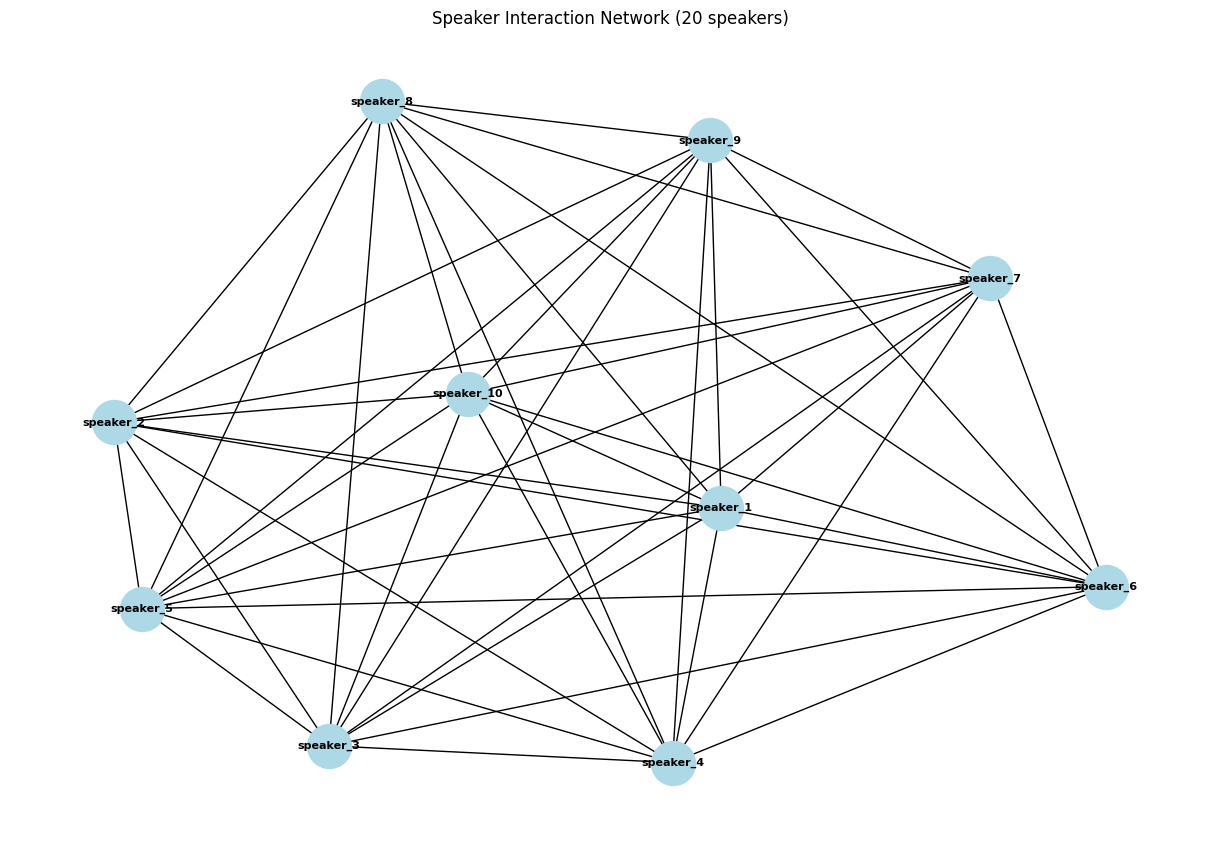

Building speaker network for 15-speaker conversation...
Network has 15 nodes and 92 edges


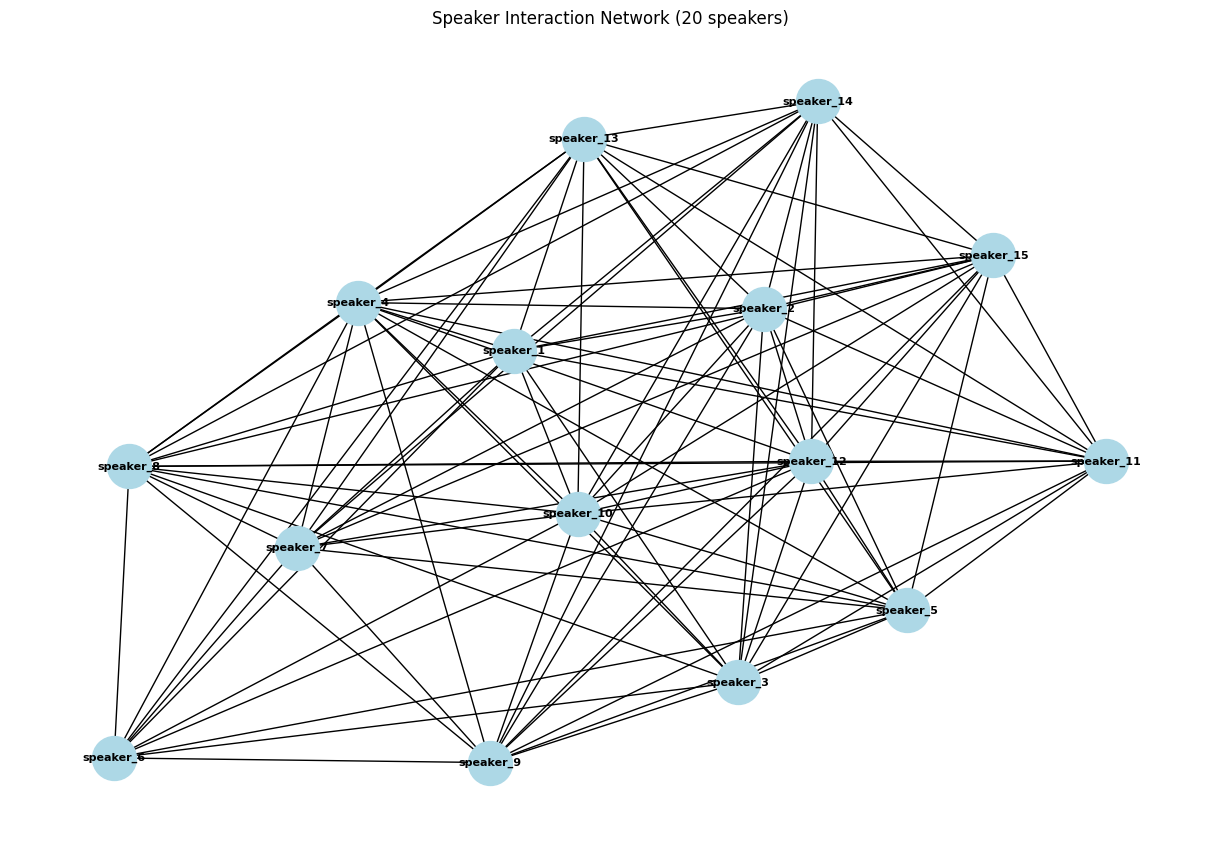

Building speaker network for 20-speaker conversation...
Network has 20 nodes and 155 edges


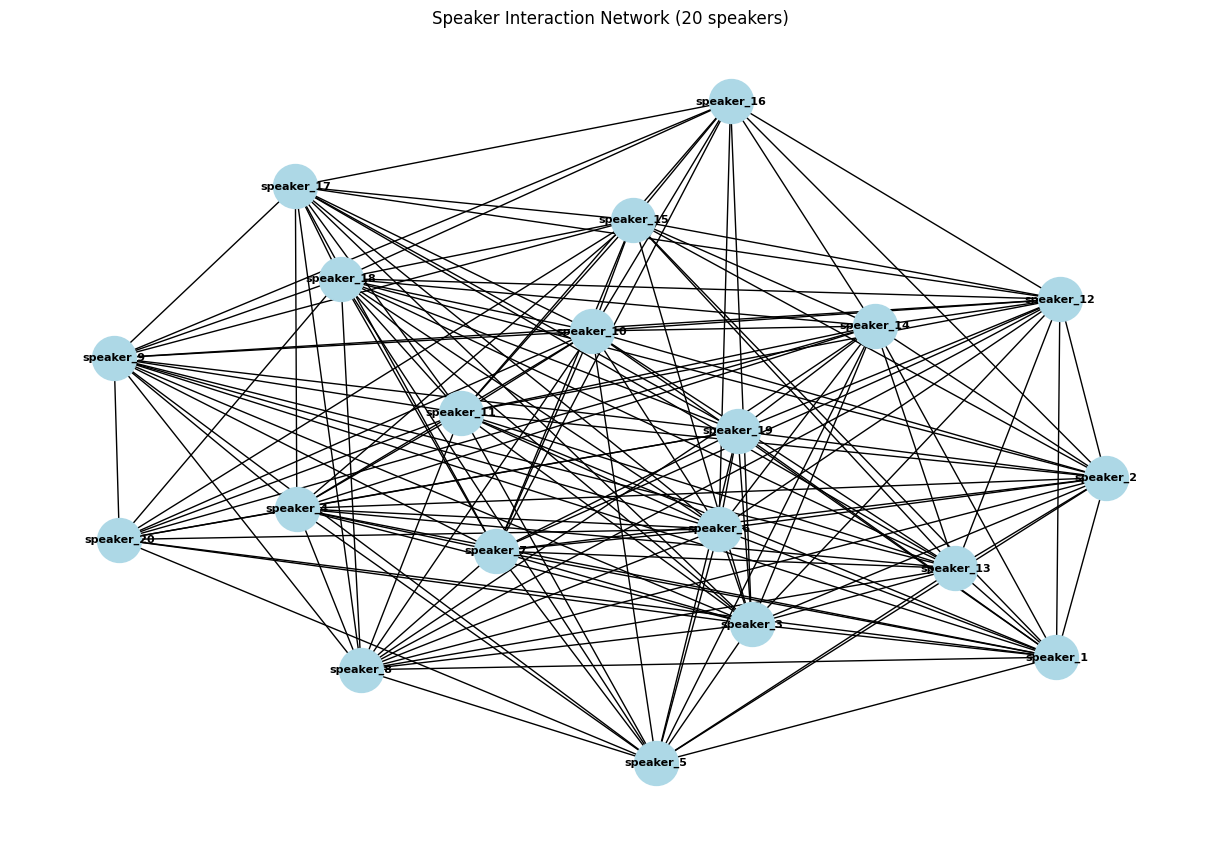

In [13]:
def build_speaker_network(conversation_history: List[Dict], window_size: int = 2) -> nx.Graph:
    """
    Build a network graph where edges represent speakers participating nearby.
    An edge exists if speaker B speaks within window_size messages after speaker A.
    """
    G = nx.Graph()
    
    # Track recent speakers
    recent_speakers = []
    
    for msg in conversation_history:
        if msg.get("role") == "assistant" and "name" in msg:
            current_speaker = msg["name"]
            
            # Add edges to recent speakers (they might be responding to)
            for prev_speaker in recent_speakers:
                if prev_speaker != current_speaker:
                    if G.has_edge(prev_speaker, current_speaker):
                        G[prev_speaker][current_speaker]["weight"] += 1
                    else:
                        G.add_edge(prev_speaker, current_speaker, weight=1)
            
            # Update recent speakers
            recent_speakers.append(current_speaker)
            if len(recent_speakers) > window_size:
                recent_speakers.pop(0)
    
    return G

for speaker_count, (conv, metrics) in results.items():
    print(f"Building speaker network for {speaker_count}-speaker conversation...")
    network = build_speaker_network(conv)

    print(f"Network has {network.number_of_nodes()} nodes and {network.number_of_edges()} edges")
    
    # Visualize
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(network, k=1, iterations=50)
    nx.draw(network, pos, with_labels=True, node_color='lightblue', 
            node_size=1000, font_size=8, font_weight='bold')
    plt.title("Speaker Interaction Network (20 speakers)")
    plt.show()


## Analysis

### Scaling Effects

1. **Dynamic Score**: How does collaboration/competition change with scale?
2. **Conclusiveness Score**: Does the improved calculation work better?
3. **Network Structure**: Do certain speakers become hubs?
4. **Conversation Quality**: Does it degrade with more speakers?

### Key Findings
- **Group Dynamics**: Larger groups may show different interaction patterns
- **Speaker Roles**: Some speakers may emerge as connectors

## Summary

Scaling to 10+ speakers reveals:

- **Metrics remain meaningful**: ConvoKit can handle larger groups
- **Network analysis**: Visualizing interactions reveals group structure

Future work could explore:
- Even larger groups (50+ speakers)
- Subgroup formation
- Conversation moderation at scale
- Performance optimization for large groups
